<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">To be or not to be?</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">Binary Classification on Artificial Medical Data</a></center>
<br/>

---

# TP1 Instructions


The goal of this TP is to work on a mortality prediction problem and to participate into the "To be or not to be?" challenge.

A fresh instance of the challenge can be found here: https://competitions.codalab.org/competitions/27605

* **Step 1:** Sign up to https://competitions.codalab.org
* **Step 2:** Go through the competition's pages and read them carefully in order to understand the problem.
* **Step 3:** Download the dataset from "Participate > Files > Public Data" page. Put the "public_data" folder in the same folder as the folder containing this notebook.
* **Step 4:** Go though this notebook. You'll have to read, run, **code your own methods** and **answer quetions**. Use "code" cell for coding and "markdown" cell to answer questions. 

_Remark: You may need to look up on the internet for information or documentation._

<b><font size="5">Outline</font></b><br/><br/>
&emsp;&emsp;&emsp; I) <a href="#data"> Load data</a><br/>
&emsp;&emsp;&emsp; II) <a href="#exploratory"> Exploratory analysis </a><br/>
&emsp;&emsp;&emsp; III) <a href="#processing"> Processing </a><br/>
&emsp;&emsp;&emsp; IV) <a href="#model"> Predictive model </a><br/>
&emsp;&emsp;&emsp; V) <a href="#save"> Save predictions </a><br/>

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import time
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np

# IMPORTS
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

### Question 1: Briefly explain the task.

TODO: answer <br>
We are to classify patients according to their given information into people who will survive vs people who will have died. This way we might be able to predict who needs more attention 

### Question 2: What is the metric used in the challenge?

TODO: answer <br>
The metric that is used accuracy, the percentage of rightfully classified instances. In balanced accuracy missclassifing(or rightly classifying for that matter) a class that is less represented has a stronger influence on the accuracy score to prevent models to simply learn to answer with the most represented class.

## <a id="data"> I) Load data</a>  

In [2]:
features = pd.read_csv(
    "../public_data/mimic_synthetic_feat.name", header=None
).values.flatten()
labels = pd.read_csv(
    "../public_data/mimic_synthetic_label.name", header=None
).values.flatten()
X = pd.read_csv(
    "../public_data/mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)
y = pd.Series(
    pd.read_csv(
        "../public_data/mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [3]:
X.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,45524,108398,2128-05-15_23:42:00,2132-07-23_15:00:00,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,...,0,0,0,0,0,0.0,0,0,0,0
1,50520,186416,2134-03-17_03:59:00,2113-03-06_12:05:00,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,...,0,0,0,0,0,0.0,0,0,0,1
2,17956,126413,2164-04-05_17:32:00,2180-09-20_16:30:00,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,...,0,0,0,0,0,0.0,0,0,0,0
3,90258,109355,2102-09-08_00:58:00,2166-06-26_15:30:00,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,...,0,0,0,0,0,0.0,0,0,1,0
4,25159,123784,2163-08-06_12:07:00,2147-01-14_18:40:00,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,...,0,0,0,0,0,0.0,0,0,0,0


In [4]:
y

0        0
1        0
2        0
3        0
4        0
        ..
79994    0
79995    0
79996    0
79997    0
79998    0
Length: 79999, dtype: int64

In [5]:
X.shape

(79999, 341)

This is the **training set**. This means that have access to the labels and you can use it in anyway you want to prepare your model.

Later on, you'll make your model draws predictions from the **testing set** in order to upload them on Codalab and get a score on unseen labels.

In [6]:
# Load testing set
X_test = pd.read_csv(
    "../public_data/mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

## <a id="exploratory"> II) Exploratory analysis</a>

#### Variable types

In [7]:
types = pd.read_csv(
    "../public_data/mimic_synthetic_feat.type", header=None
).set_index(features)[0]
print(types.value_counts())

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64


#### Labels distribution

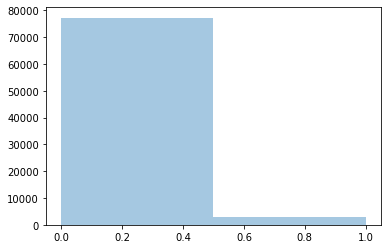

In [8]:
sns.distplot(y, bins=2, kde=False)

### Code 1: Display the following plots:
* Bar plots of some categorical variables (e.g. "LANGUAGE", "MARITAL_STATUS")

* Show the correlation between some variables and the target variable y.

* Another plot or any exploratory analysis you can think of

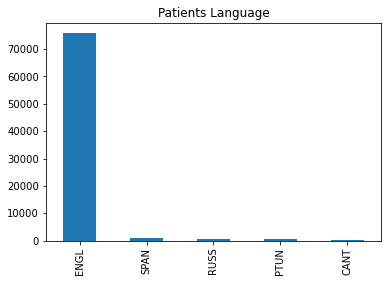

In [9]:
X['LANGUAGE'].value_counts()[:5].plot(kind='bar', title="Patients Language")

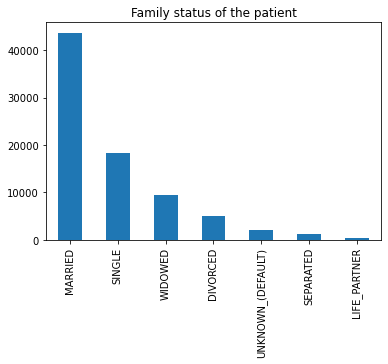

In [10]:
X['MARITAL_STATUS'].value_counts().plot(kind='bar', title="Family status of the patient")

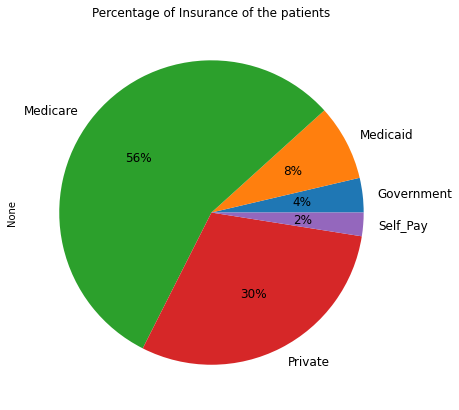

In [11]:
plt.figure(figsize=(7,7))
X.groupby('INSURANCE').size().plot(kind='pie',autopct='%1.0f%%',  textprops={'fontsize': 12}, title="Percentage of Insurance of the patients")
plt.show()

In [18]:
X.columns.to_list()

['SUBJECT_ID',
 'HADM_ID',
 'ADMITTIME',
 'DISCHTIME',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY',
 'GENDER',
 'AGE',
 'HR_MIN_DAY1',
 'HR_MAX_DAY1',
 'HR_MEAN_DAY1',
 'SYS_BP_MIN_DAY1',
 'SYS_BP_MAX_DAY1',
 'SYS_BP_MEAN_DAY1',
 'DIAS_BP_MIN_DAY1',
 'DIAS_BP_MAX_DAY1',
 'DIAS_BP_MEAN_DAY1',
 'MEAN_BP_MIN_DAY1',
 'MEAN_BP_MAX_DAY1',
 'MEAN_BP_MEAN_DAY1',
 'RESP_RATE_MIN_DAY1',
 'RESP_RATE_MAX_DAY1',
 'RESP_RATE_MEAN_DAY1',
 'TEMP_MIN_DAY1',
 'TEMP_MAX_DAY1',
 'TEMP_MEAN_DAY1',
 'SPO2_MIN_DAY1',
 'SPO2_MAX_DAY1',
 'SPO2_MEAN_DAY1',
 'GLUCOSE_MIN_DAY1',
 'GLUCOSE_MAX_DAY1',
 'GLUCOSE_MEAN_DAY1',
 'HR_MIN_DAY2',
 'HR_MAX_DAY2',
 'HR_MEAN_DAY2',
 'SYS_BP_MIN_DAY2',
 'SYS_BP_MAX_DAY2',
 'SYS_BP_MEAN_DAY2',
 'DIAS_BP_MIN_DAY2',
 'DIAS_BP_MAX_DAY2',
 'DIAS_BP_MEAN_DAY2',
 'MEAN_BP_MIN_DAY2',
 'MEAN_BP_MAX_DAY2',
 'MEAN_BP_MEAN_DAY2',
 'RESP_RATE_MIN_DAY2',
 'RESP_RATE_MAX_DAY2',
 'RESP_RATE_MEAN_DAY2',
 'TEMP_MIN_DAY2',
 'TEMP_MAX_DAY2',
 'TEMP_MEAN_DAY2',
 'SPO2_M

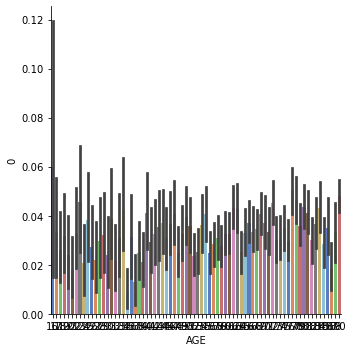

In [32]:
ages = X['AGE']
dlg = pd.concat([ages,y], axis=1)
sns.factorplot(x="AGE", y=0,data=dlgp, kind="bar", palette="muted")

In [23]:
print(ages)
print(y)
pd.DataFrame(ages,y)

0        21
1        39
2        40
3        75
4        55
         ..
79994    76
79995    38
79996    90
79997    57
79998    37
Name: AGE, Length: 79999, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
79994    0
79995    0
79996    0
79997    0
79998    0
Length: 79999, dtype: int64


,AGE
0,21
0,21
0,21
0,21
0,21
...,...
0,21
0,21
0,21
0,21


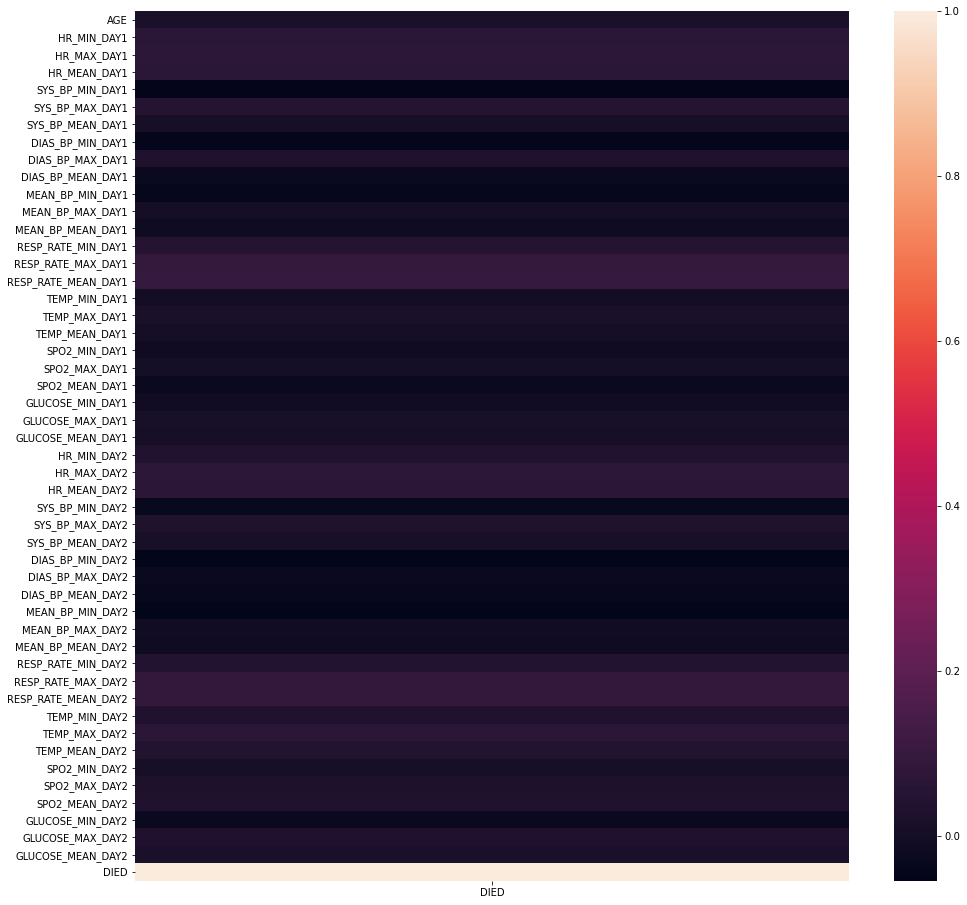

In [14]:
pour_corr = X.copy()

pour_corr = pour_corr[X.columns.values[2:60]]
pour_corr["DIED"] = y

corr = pour_corr.corr()

import seaborn as sns

plt.figure(figsize=(16, 16))

# print(corr)
vals = corr.values[:, -1].reshape(-1,1)

sns.heatmap(vals, 
        xticklabels=[corr.columns[-1]],
        yticklabels=corr.columns)

plt.show()

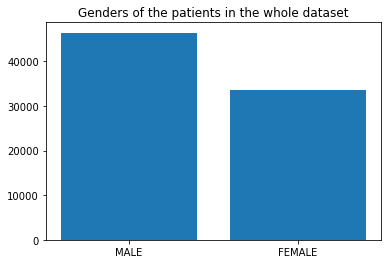

In [15]:
F = [len(X[X["GENDER"] == "M"]) , len(X[X["GENDER"] == "F"])]

plt.bar(["MALE","FEMALE"], F )
plt.title("Genders of the patients in the whole dataset")
plt.show()

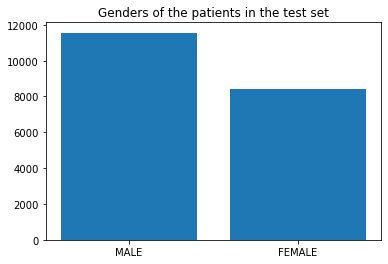

In [16]:
F = [len(X_test[X_test["GENDER"] == "M"]) , len(X_test[X_test["GENDER"] == "F"])]

plt.bar(["MALE","FEMALE"], F )
plt.title("Genders of the patients in the test set")
plt.show()

In [17]:
# X["death"] = y
# Xm = X[X["GENDER"] == "M"]
# Xm = Xm[Xm["death"]==1]

# Xf = X[X["GENDER"] == "F"]
# Xf = Xf[Xf["death"]==1]

# F2 = [len(Xm),len(Xf)]
# F2 = np.divide(F2,F)
# plt.title("proportion of death depending on the gender")
# plt.bar(["Male", "Female"], F2)

You can use markdown cells to add interesting comments.

## <a id="processing"> III) Processing</a>

As you may have noticed, various variables are categorical and encoded with strings. Most models won't be able to take them as input.

### Code 2: Transform the categorical data into integers using the encoding of your choice.

_Hint: The simplest methods is called "Label Encoding". It simply consists in replacing each new category you encounter by the integer, starting from 0. It may not be the most efficient method._

In [ ]:
X

In [17]:
X.columns.to_list()

['SUBJECT_ID',
 'HADM_ID',
 'ADMITTIME',
 'DISCHTIME',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY',
 'GENDER',
 'AGE',
 'HR_MIN_DAY1',
 'HR_MAX_DAY1',
 'HR_MEAN_DAY1',
 'SYS_BP_MIN_DAY1',
 'SYS_BP_MAX_DAY1',
 'SYS_BP_MEAN_DAY1',
 'DIAS_BP_MIN_DAY1',
 'DIAS_BP_MAX_DAY1',
 'DIAS_BP_MEAN_DAY1',
 'MEAN_BP_MIN_DAY1',
 'MEAN_BP_MAX_DAY1',
 'MEAN_BP_MEAN_DAY1',
 'RESP_RATE_MIN_DAY1',
 'RESP_RATE_MAX_DAY1',
 'RESP_RATE_MEAN_DAY1',
 'TEMP_MIN_DAY1',
 'TEMP_MAX_DAY1',
 'TEMP_MEAN_DAY1',
 'SPO2_MIN_DAY1',
 'SPO2_MAX_DAY1',
 'SPO2_MEAN_DAY1',
 'GLUCOSE_MIN_DAY1',
 'GLUCOSE_MAX_DAY1',
 'GLUCOSE_MEAN_DAY1',
 'HR_MIN_DAY2',
 'HR_MAX_DAY2',
 'HR_MEAN_DAY2',
 'SYS_BP_MIN_DAY2',
 'SYS_BP_MAX_DAY2',
 'SYS_BP_MEAN_DAY2',
 'DIAS_BP_MIN_DAY2',
 'DIAS_BP_MAX_DAY2',
 'DIAS_BP_MEAN_DAY2',
 'MEAN_BP_MIN_DAY2',
 'MEAN_BP_MAX_DAY2',
 'MEAN_BP_MEAN_DAY2',
 'RESP_RATE_MIN_DAY2',
 'RESP_RATE_MAX_DAY2',
 'RESP_RATE_MEAN_DAY2',
 'TEMP_MIN_DAY2',
 'TEMP_MAX_DAY2',
 'TEMP_MEAN_DAY2',
 'SPO2_M

In [26]:
pd.unique(X[['Tuberculosis', 'Immuniz/scrn', 'AcuteMI', 'Coronathero', 'Chestpain', 'Pulmhartdx', 'Othheartdx', 'Conduction', 'Dysrhythmia', 'Cardiaarrst', 'chf;nonhp', 'AcuteCVD', 'Hd/nckcancr', 'Precereoccl', 'OtherCVD', 'TIA', 'LateeffCVD', 'Peripathero', 'Aneurysm', 'Artembolism', 'Otcirculdx', 'Phlebitis', 'Varicosevn', 'Esophcancer', 'Hemmorhoids', 'Othveindx', 'Pneumonia', 'Influenza', 'Tonsillitis', 'Bronchitis', 'Otuprspin', 'COPD', 'Asthma', 'Asppneumon', 'Stomchcancr', 'Pleurisy', 'Adltrespfl', 'Lungexternl', 'Othlowresp', 'Otupprresp', 'Intestinfct', 'Teethdx', 'Mouthdx', 'Esophgealdx', 'Gasduoulcer', 'Coloncancer', 'Gastritis', 'Otdxstomch', 'Appendicitis', 'Abdomhernia', 'Ulceratcol', 'Intobstruct', 'Diverticulos', 'Anal/rectal', 'Peritonitis', 'Biliarydx', 'Rctm/anusca', 'Othliverdx', 'Pancreasdx', 'GIhemorrhag', 'Gastroent', 'OtherGIdx', 'Nephritis', 'Acrenlfail', 'Chrrenfail', 'UTI', 'Liver/ibdca', 'Urinstone', 'Otdxkidney', 'Otdxbladdr', 'OtherGUdx', 'BPH', 'Infmalegen', 'Othmalegen', 'Breastdx', 'PID', 'Endometrios', 'Pancreascan', 'Prolapse', 'Menstrualdx', 'Ovariancyst', 'Menopausldx', 'Feminfertil', 'Otfemalgen', 'Contraceptiv', 'Spontabortn', 'Inducabortn', 'Abortcompl', 'GI/peritcan', 'Ectopicpreg', 'Otpregcomp', 'Hemorrpreg', 'HTNinpreg', 'Earlylabor', 'Longpregncy', 'DMinpreg', 'Malposition', 'Pelvicobstr', 'Prevc-sectn', 'Brnch/lngca', 'Fetaldistrs', 'Amniosdx', 'Umbilcord', 'OB-relatedperintrauma', 'Otcomplbir', 'Nmlpreg/del', 'Skininfectn', 'Otinflskin', 'Ulcerskin', 'Septicemia', 'Otrespirca', 'Othskindx', 'Infectarth', 'Rheumarth', 'Osteoarthros', 'Otjointdx', 'Backproblem', 'Osteoporosis', 'Pathologfx', 'Acqfootdef', 'Otacqdefor', 'Bone/ctcncr', 'SLE', 'Otconntiss', 'Otbonedx', 'Cardiacanom', 'GIconganom', 'guconganom', 'Nervcongan', 'Otconganom', 'Liveborn', 'Lowbirthwt', 'Skinmelanom', 'Birthasphyx', 'Respdistres', 'Perintjaund', 'Birthtrauma', 'Otperintdx', 'Jointinjury', 'Fxhip', 'Spincorinj', 'Fxskullfac', 'Fxarm', 'Non-epithca', 'Fxleg', 'Othfracture', 'Sprain', 'Intracrninj', 'Crushinjury', 'Opnwndhead', 'Opnwndextr', 'Complicdevi', 'Complicproc', 'Superficinj', 'Breastcancr', 'Burns', 'Poisonpsych', 'Poisnotmed', 'Poisnnonmed', 'Otherinjury', 'Syncope', 'FUO', 'Lymphenlarg', 'Gangrene', 'Shock', 'Uteruscancr', 'Nausea/vomit', 'Abdomnlpain', 'Fatigue', 'Allergy', 'Socialadmin', 'Exam/eval', 'Otaftercare', 'Otherscreen', 'Unclassified', 'Cervixcancr', 'ECodes:Cut/pierce', 'ECodes:Drowning/submersion', 'ECodes:Fall', 'ECodes:Fire/burn', 'ECodes:Firearm', 'ECodes:Machinery', 'ecodes:motorvehicletraffic(mvt)', 'ECodes:Pedalcyclist-notMVT', 'ECodes:Pedestrian-notMVT', 'ecodes:transport-notmvt', 'ECodes:Natural/environment', 'ECodes:Overexertion', 'ECodes:Poisoning', 'ECodes:Struckby-against', 'ECodes:Suffocation', 'ECodes:Adverseeffectsofmedicalcare', 'ECodes:Adverseeffectsofmedicaldrugs', 'ECodes:Otherspecifiedandclassifiable', 'ecodes:otherspecified-nec', 'ECodes:Unspecified', 'ECodes:Placeofoccurrence', 'Ovarycancer', 'Femgenitca', 'Prostatecan', 'Othbactinf', 'Testiscancr', 'Malgenitca', 'Bladdercncr', 'Kidny/rnlca', 'Urinyorgca', 'Brain/nscan', 'Thyroidcncr', 'Hodgkin-sds', 'Non-Hodglym', 'Leukemias', 'Mycoses', 'Multmyeloma', 'Otprimryca', '2ndarymalig', 'Maligneopls', 'Neoplsmunsp', 'Maintchem/r', 'Bnignutneo', 'Otbnignneo', 'Thyroiddsor', 'DiabMelnoc', 'HIVinfectn', 'DiabMelw/cm', 'Otendodsor', 'Nutritdefic', 'Hyperlipidem', 'Gout/otcrys', 'Fluid/elcdx', 'Cysticfibro', 'Immunitydx', 'Otnutritdx', 'Anemia', 'Hepatitis', 'Acutp-hanm', 'Sicklecell', 'Coag/hemrdx', 'Whtblooddx', 'Othematldx', 'Adjustmentdisorders', 'Anxietydisorders', 'Attention-deficit/conduct/disruptivebeha', 'Delirium/dementia/amnestic/othercognitiv', 'Developmentaldisorders', 'Disordersusuallydiagnosedininfancy/ch', 'ImpulsecontroldisordersNEC', 'Mooddisorders', 'Personalitydisorders', 'Schizophreniaandotherpsychoticdisorde', 'Alcohol-relateddisorders', 'Substance-relateddisorders', 'Suicideandintentionalself-inflictedin', 'Screeningandhistoryofmentalhealthan', 'Miscellaneousmentaldisorders', 'Viralinfect', 'Meningitis', 'Encephalitis', 'OthCNSinfx', 'Parkinson-s', 'Othinfectns', 'MS', 'OtheredCNS', 'Paralysis', 'Epilepsy/cnv', 'Headache/mig', 'Coma/brndmg', 'Cataract', 'Retinaldx', 'Glaucoma', 'Blindness', 'SexualInfxs', 'Eyeinfectn', 'Othereyedx', 'Otitismedia', 'Dizziness', 'Othereardx', 'Othnervdx', 'Hrtvalvedx', 'Carditis', 'HTN', 'Htncomplicn']].values.ravel('K'))


array([ 0.,  1., nan])

In [ ]:
# columns = X.columns[X.dtypes == 'object']
# for column in columns:
#     X[column] = X[column].astype('category').cat.codes

In [ ]:
columns = X.columns[X.dtypes == 'object'].tolist() + ["AGE"]
def clearing(df):
    df = df.copy()
    cols = ['SUBJECT_ID', 'HADM_ID']#[col for col in df.columns if "ID" in col]
    for col in cols:
        df.pop(col)
    df["ADMITTIME"] = pd.to_datetime(df["ADMITTIME"].apply(lambda a: a.replace("_", " "))).apply(lambda x:x.timestamp())
    df["DISCHTIME"] = pd.to_datetime(df["DISCHTIME"].apply(lambda a: a.replace("_", " "))).apply(lambda x:x.timestamp())
    df["length_stay"] = df["DISCHTIME"] - df["ADMITTIME"]
    df["length_stay"] = (df["length_stay"] - df["length_stay"].min())/(df["length_stay"].max() - df["length_stay"].min())
    df["ADMITTIME"] = (df["ADMITTIME"] - df["ADMITTIME"].min())/(df["ADMITTIME"].max() - df["ADMITTIME"].min())
    df["DISCHTIME"] = (df["DISCHTIME"] - df["DISCHTIME"].min())/(df["DISCHTIME"].max() - df["DISCHTIME"].min())
#     df = pd.get_dummies(df)
#     df.pop('ADMITTIME')
#     df.pop('DISCHTIME')
    columns = df.columns[df.dtypes == 'object']
    for column in columns:
        df[column] = df[column].astype('category').cat.codes
        

    return df

df = clearing(X)
df

In [ ]:
y

In [ ]:
#down  sampling; throw away some of the data
def down_sample(df, labels):
    pos_number = labels.sum()
    new_labels = labels.loc[labels == 1]
    new_labels = new_labels.append(labels.loc[labels==0].sample(pos_number))
    return df.loc[new_labels.index].reset_index(), new_labels.reset_index()

#up sampling, copying rows with a positive values
def up_sample(df, labels, length=1500):
    new_labels = labels.loc[labels==1].sample(length)
    new_df = df.append(df.loc[new_labels.index])
    return new_df.reset_index(), new_labels.reset_index()
    
down_sample(X,y)
up_sample(X,y,1000)

In [ ]:
# X["ADMITTIME"].apply(lambda a: a.replace("_", " "))

In [ ]:
# pd.to_datetime(X["ADMITTIME"].apply(lambda a: a.replace("_", " "))).apply(lambda x:x.timestamp())

In [ ]:
X_encoded = clearing(X)

In [ ]:
X_encoded.shape

In [ ]:
X_encoded

In [ ]:
X_test_encoded = clearing(X_test)

In [ ]:
X_test_encoded.shape

In [ ]:
X_test_encoded = X_test_encoded.reindex(columns = X_encoded.columns, fill_value=0)
X_test_encoded.shape

In [ ]:
X_encoded = X_encoded.reindex(columns = X_test_encoded.columns, fill_value=0)
X_encoded.shape

In [ ]:
X_test_encoded = X_test_encoded.fillna(method="pad")#(X.mean())#(method="pad")
X_encoded = X_encoded.fillna(method="pad")#(X_encoded.mean())#(method="pad")


In [ ]:
nan_values = X_encoded.isna()
nan_columns = nan_values.any()

columns_with_nan = X_encoded.columns[nan_columns].tolist()
print(columns_with_nan)

In [ ]:
[col for col in X_encoded.columns if "ID" in col]

In [ ]:
columns

In [ ]:
np.unique(X_encoded["ECodes:Adverseeffectsofmedicalcare"])

## <a id="model"> IV) Predictive model</a>

Train a model and assess its performance.

In [ ]:
from sklearn.svm import SVC, LinearSVC
from  sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

clf = XGBClassifier(n_estimators=20, max_depth=5, n_jobs=-1)

# clf = LGBMClassifier()

# clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# clf = DecisionTreeClassifier()
# clf = LogisticRegression(solver="saga", penalty="l2", fit_intercept=True)
# clf = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(128, 7), random_state=1, activation="logistic", max_iter=1000)
# clf = SVC()
# clf = LinearSVC(random_state=0, tol=1e-5, max_iter=100, dual=False)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
def new_model():
    model = Sequential()

    model.add(Dense(64, input_dim=340))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(8))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



In [ ]:
saved = {}

def normalize(df, use_saved=False):
    result = df.copy()
    for feature_name in df.columns :
#         if feature_name not in columns:
        if use_saved:
            max_value, min_value = saved[feature_name]
        else:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            saved[feature_name] = (max_value, min_value)
        second = max_value - min_value
        if second == 0:
            result[feature_name] = 0
        else:
            result[feature_name] = (df[feature_name] - min_value) / second
    return result


In [ ]:
saved = {}
print(columns)
def normalize(df, use_saved=False):
    result = df.copy()
    for feature_name in df.columns :
        if feature_name not in columns:
            if use_saved:
                std_value, mean_value = saved[feature_name]
            else:
                std_value = df[feature_name].std()
                mean_value = df[feature_name].mean()
                saved[feature_name] = (std_value, mean_value)
            second = std_value
            if second == 0:
                result[feature_name] = 0
            else:
                result[feature_name] = (df[feature_name] - mean_value) / second
    return result


In [ ]:
from sklearn.decomposition import PCA
X_encoded_copy = X_encoded.copy()
# X_encoded_copy.pop('ECodes:Adverseeffectsofmedicalcare')
# clf = svm.SVC()

# mod = PCA(100)
# X_encoded_copy = mod.fit_transform(X_encoded_copy)

X_encoded_copy = normalize(X_encoded_copy)
# X_encoded_copy = X_encoded_copy[df_upsampled.columns[important_features_list[:20]].tolist()]


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X_encoded_copy, y, test_size=0.2
)  # train/validation split

In [ ]:
from sklearn.utils import resample


df_majority = x_train[y_train==0]
df_minority = x_train[y_train==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=int(df_majority.shape[0]),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

new_y = np.concatenate([np.zeros(df_majority.shape[0]), np.ones(df_minority_upsampled.shape[0])])


df_upsampled.shape, df_majority.shape, df_minority_upsampled.shape, y_train.shape, new_y.shape

In [ ]:
clf.fit(df_upsampled, new_y)  # training
y_pred = clf.predict(x_valid)  # predictions
score = balanced_accuracy_score(y_valid, y_pred)  # scoring
print("Balanced accuracy score: {}".format(score))

In [ ]:
important_features_dict = {}
for x,i in enumerate(clf.feature_importances_):
    important_features_dict[x]=i

important_features_dict = dict(sorted(important_features_dict.items(), key=lambda item: item[1], reverse=True))
print(important_features_dict)
# important_features_list = sorted(important_features_dict,
#                                  key=important_features_dict.get,
#                                  reverse=False)
important_features_list = list(important_features_dict.keys())
df_upsampled.columns[important_features_list].tolist()

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
scores=[]
for i in X_encoded_copy.columns:
    x_train, x_valid, y_train, y_valid = train_test_split(
    X_encoded_copy[[i]], y, test_size=0.3
    )
    reg = LogisticRegression(max_iter=100).fit(x_train, y_train)
    y_pred = reg.predict(x_valid)  # predictions
    score = balanced_accuracy_score(y_valid, abs(y_pred.round()))  # scoring
    scores.append((score,i))


In [ ]:
def attrget(elem):
    return elem[0]

sco = sorted(scores, key=attrget)
# sco = [sc for sc in sco if sc[0]>0.5]
print( [sc for sc in sco if sc[0]>0.5])

    
print(X_encoded_copy.shape)

In [ ]:
from keras.callbacks import Callback

class MyLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(x_valid).reshape(-1)  # predictions
        y_pred[y_pred <= 0.5] = 0
        y_pred[y_pred>0.5] = 1
        score = balanced_accuracy_score(y_valid, y_pred)  # scoring
        print("Balanced accuracy score: {}".format(score))

model = new_model()
history = model.fit(df_upsampled, new_y, epochs=100, batch_size=512, validation_data=(x_valid, y_valid), callbacks=[MyLogger()])

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def compute_accuracy(data, target, name="", disp=False):
    data = torch.FloatTensor(data).cuda()
    data = Variable(data)

    y_pred = net(data)
    y_pred = y_pred.detach().cpu().numpy().reshape(-1)  # predictions
    y_pred[y_pred <= 0.5] = 0
    y_pred[y_pred>0.5] = 1
    score = balanced_accuracy_score(target, y_pred)  # scoring
    if disp: print(name, "balanced accuracy score: {}".format(score))
    return score

In [ ]:
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(340, 64)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 16)
        self.drop3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = F.relu(self.drop1(self.fc1(x)))
        x = F.relu(self.drop2(self.fc2(x)))
        x = F.relu(self.drop3(self.fc3(x)))
        x = self.fc4(x)
        return self.sigmoid(x)
    
net = Net().cuda()
learning_rate = 0.0001
epochs = 10
batch_size=1024
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# create a loss function
criterion = nn.BCELoss()

batch_count = df_upsampled.shape[0]/batch_size
if batch_count - int(batch_count)>0: batch_count = int(batch_count)+1
    
log_interval = batch_count

df_upsampled_values = df_upsampled.values




In [ ]:
for epoch in range(epochs*4):
    for batch_idx in range(batch_count):
        start, end = int(batch_idx*batch_size), int(batch_idx*batch_size+batch_size)
        data, target = df_upsampled_values[start:end], new_y[start:end].reshape((-1,1))
        data, target = torch.FloatTensor(data).cuda(), torch.Tensor(target).cuda()
        data, target = Variable(data), Variable(target)
        # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
        data = data.view(-1, 340)
        optimizer.zero_grad()
        net_out = net(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            score = compute_accuracy(df_upsampled_values, new_y, name="Train", disp=False)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTrain accuracy: {:.6f}'.format(
                    epoch, batch_idx * len(data), df_upsampled.shape[0],
                           100. * batch_idx / batch_count, loss.detach().cpu().numpy(), score))
            
compute_accuracy(x_valid.values, y_valid.values, name="Test", disp=True)

In [ ]:
compute_accuracy(x_valid.values, y_valid.values, name="Test", disp=True)

In [ ]:
test_loss = 0
correct = 0
for data, target in zip(df_upsampled_values, new_y.reshape((-1,1))):
    data, target = data.reshape((1,-1)), target.reshape((-1,1))
    data, target = torch.FloatTensor(data).cuda(), torch.Tensor(target).cuda()
    data, target = Variable(data, volatile=True), Variable(target)
#     data = data.view(-1, 28 * 28)
    net_out = net(data)
    # sum up batch loss
#     print(net_out.shape, target.shape)
    test_loss += criterion(net_out, target).detach().cpu().numpy()
    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    correct += pred.eq(target.data).sum()

test_loss /= df_upsampled_values.shape[0]
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
test_loss

In [ ]:
y_pred = model.predict(x_valid).reshape(-1)  # predictions
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred>0.5] = 1
score = balanced_accuracy_score(y_valid, y_pred)  # scoring
print("Balanced accuracy score: {}".format(score))

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

### Code 3: the code above uses a simple "hold out" method to get the validation score. Use cross-validation to get a more stable estimation.

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, df_upsampled, new_y, cv=5, scoring='f1_macro')

### Code 4: Try to improve your score by using at least one of the following methods:

* Hyperparameter search
* Model selection
* Data augmentation

In [ ]:
# TODO:
# Hyperparameter search
# Model selection
# Data augmentation

### Question 3: What is up-sampling? Why it may be worth a try for this problem?

TODO: answer
When upsampling one amplifies the signal of a class by reusing instances of it in the learning process. This is interesting for this task since we have very little data for the class of people who died in the hospital. Reusing some of the "dead" cases trains the model to make more balanced predictions.



## <a id="save"> V) Save Predictions</a>

* Use the following code to make predictions and save them as a ZIP file.
* Try to upload this ZIP file into the competition ("Participate > Submit/ View Results > Submit")
* Do your best to be **on top of the leaderboard!**

In [ ]:
X_test_encoded_copy = X_test_encoded.copy()

# X_test_encoded_copy.pop('ECodes:Adverseeffectsofmedicalcare')
# X_test_encoded_copy.pop('Otnutritdx')
# X_test_encoded_copy.pop('Othnervdx')

# X_test_encoded_copy = mod.transform(X_test_encoded_copy)

X_test_encoded_copy= normalize(X_test_encoded_copy, use_saved=False)

In [ ]:
predictions = model.predict(X_test_encoded_copy).reshape(-1)  # compute predictions (0 and 1)
predictions[predictions <= 0.5] = 0
predictions[predictions>0.5] = 1
predictions_file = "mimic_synthetic_test.csv"
pd.Series(predictions).to_csv(predictions_file, index=False, header = False)
print("Predictions saved.")
t = time.asctime().replace(" ", "_").replace(":", "-")
output_file = "submission_" + t + ".zip"
!zip test_submission.zip mimic_synthetic_test.csv # create a ZIP
with ZipFile(output_file, "w") as z:
    z.write(predictions_file)
print("The submission is ready: {}".format(output_file))

In [ ]:
X_test_encoded_copy.values.shape, x_valid.shape

### Interesting to know!

The dataset doesn't contain actual medical data. We are not allowed to share with you such **confidential data** from critical care patients. To avoid that problem, we replaced the data by **artificial data**. 

In order to have credible data, we have generated them using a **Wasserstein GAN**.

For more information, here is a reference: <br />
Privacy Preserving Synthetic Health Data <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />
https://hal.inria.fr/hal-02160496/document